# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: April 19, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment. This code analyzes merged biological replicates corresponding to the same genotype.

In [2]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [3]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-merged-TE.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [4]:
data_matrix

,Col-1.TE.merge.140-160,Col-1.TE.merge.140-160.1,Col-1.TE.merge.140-160.2,Col-1.TE.merge.140-160.3,Col-1.TE.merge.140-160.4,Col-1.TE.merge.140-160.5,Col-1.TE.merge.140-160.6,Col-1.TE.merge.140-160.7,Col-1.TE.merge.140-160.8,Col-1.TE.merge.140-160.9,...,R17A-2.TE.merge.140-160.190,R17A-2.TE.merge.140-160.191,R17A-2.TE.merge.140-160.192,R17A-2.TE.merge.140-160.193,R17A-2.TE.merge.140-160.194,R17A-2.TE.merge.140-160.195,R17A-2.TE.merge.140-160.196,R17A-2.TE.merge.140-160.197,R17A-2.TE.merge.140-160.198,R17A-2.TE.merge.140-160.199
0,0.000000,0.001385,0.009235,0.009697,0.03279,0.07989,0.07388,0.07342,0.05449,0.01108,...,0.24680,0.218500,0.193900,0.10950,0.08258,0.167000,0.16560,0.19530,0.19390,0.129900
1,0.029090,0.023090,0.018470,0.016160,0.00785,0.02078,0.05172,0.08312,0.11410,0.10850,...,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000
2,0.001385,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.02041,0.043610,0.076080,0.14380,0.14660,0.123400,0.09742,0.04082,0.05149,0.105300
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.05474,0.012530,0.000000,0.00000,0.00000,0.001392,0.01067,0.03433,0.03711,0.040820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31184,0.036940,0.022160,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.10900,0.006031,0.002783,0.02691,0.04175,0.055670,0.05289,0.02876,0.01438,0.010670
31185,0.066490,0.030010,0.003232,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.03618,0.027830,0.025510,0.01067,0.03340,0.046390,0.04639,0.04222,0.01438,0.024120
31186,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11320,0.111300,0.097420,0.02783,0.01392,0.000000,0.00000,0.00000,0.00000,0.000000
31187,0.002771,0.036940,0.064190,0.076190,0.10110,0.10020,0.11130,0.11590,0.10620,0.07527,...,0.01856,0.018560,0.016240,0.02876,0.04639,0.046390,0.04639,0.01809,0.00000,0.005103


In [5]:
#Matrix containing gene names corresponding to each row of data_matrix
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-merged-TE.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names
gene_names = sorted_genes['name'].copy()

In [6]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [7]:
metadata

,Col-1.TE.merge.140-160,Col-1.TE.merge.140-160.1,Col-1.TE.merge.140-160.2,Col-1.TE.merge.140-160.3,Col-1.TE.merge.140-160.4,Col-1.TE.merge.140-160.5,Col-1.TE.merge.140-160.6,Col-1.TE.merge.140-160.7,Col-1.TE.merge.140-160.8,Col-1.TE.merge.140-160.9,...,R17A-2.TE.merge.140-160.191,R17A-2.TE.merge.140-160.192,R17A-2.TE.merge.140-160.193,R17A-2.TE.merge.140-160.194,R17A-2.TE.merge.140-160.195,R17A-2.TE.merge.140-160.196,R17A-2.TE.merge.140-160.197,R17A-2.TE.merge.140-160.198,R17A-2.TE.merge.140-160.199,gene name
0,0.000000,0.001385,0.009235,0.009697,0.03279,0.07989,0.07388,0.07342,0.05449,0.01108,...,0.218500,0.193900,0.10950,0.08258,0.167000,0.16560,0.19530,0.19390,0.129900,AT1TE00010
1,0.029090,0.023090,0.018470,0.016160,0.00785,0.02078,0.05172,0.08312,0.11410,0.10850,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,AT1TE00020
2,0.001385,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,AT1TE00025
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.043610,0.076080,0.14380,0.14660,0.123400,0.09742,0.04082,0.05149,0.105300,AT1TE00030
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.012530,0.000000,0.00000,0.00000,0.001392,0.01067,0.03433,0.03711,0.040820,AT1TE00150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31184,0.036940,0.022160,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.006031,0.002783,0.02691,0.04175,0.055670,0.05289,0.02876,0.01438,0.010670,AT5TE96875
31185,0.066490,0.030010,0.003232,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.027830,0.025510,0.01067,0.03340,0.046390,0.04639,0.04222,0.01438,0.024120,AT5TE96880
31186,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.111300,0.097420,0.02783,0.01392,0.000000,0.00000,0.00000,0.00000,0.000000,AT5TE96885
31187,0.002771,0.036940,0.064190,0.076190,0.10110,0.10020,0.11130,0.11590,0.10620,0.07527,...,0.018560,0.016240,0.02876,0.04639,0.046390,0.04639,0.01809,0.00000,0.005103,AT5TE97000


## Plot sum of all genes

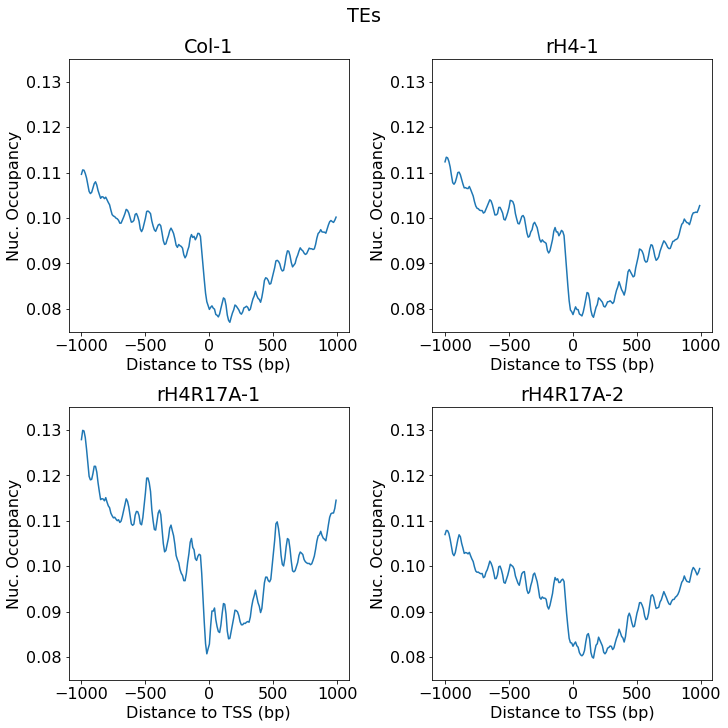

In [8]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)/27443

#Split data by sample
Col_1_data = rowsum[0:200].tolist()
H4WT_1_data = rowsum[200:400].tolist()
R17A_1_data = rowsum[400:600].tolist()
R17A_2_data = rowsum[600:800].tolist()

#Plot data
plt.rcParams.update({'font.size': 16})
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.set_size_inches(10, 10)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy', ylim=[0.075,0.135])
axs[0, 0].plot(x_vals, Col_1_data)
axs[0, 0].set_title('Col-1')

axs[0, 1].plot(x_vals, H4WT_1_data)
axs[0, 1].set_title('rH4-1')

axs[1, 0].plot(x_vals, R17A_1_data)
axs[1, 0].set_title('rH4R17A-1')

axs[1, 1].plot(x_vals, R17A_2_data)
axs[1, 1].set_title('rH4R17A-2')

fig.suptitle('TEs')
plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/merged")

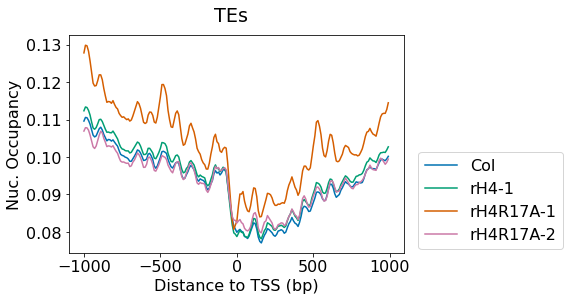

In [9]:
#Plot all data on same plot
plt.rcParams.update({'font.size': 16})
plt.style.use('seaborn-colorblind')
x_vals = np.arange(-1000,1000,10)
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('Nuc. Occupancy')
plt.plot(x_vals, Col_1_data, label='Col')
plt.plot(x_vals, H4WT_1_data, label='rH4-1')
plt.plot(x_vals, R17A_1_data, label='rH4R17A-1')
plt.plot(x_vals, R17A_2_data, label='rH4R17A-2')
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0))
plt.suptitle('TEs')
plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/merged_oneplot",bbox_inches='tight',dpi=500)

## Combine nucleosome positioning data with expression data from RNA-seq

In [10]:
#Load TE expression data
def rnaseq_load(path1,path2):
    #Load and merge files corresponding to 2 replicates
    tpm_file1 = pd.read_csv(path1, sep='\t', header=0)
    tpm_file1.columns = ['gene name',"rep1"]
    tpm_file2 = pd.read_csv(path2, sep='\t', header=0)
    tpm_file2.columns = ['gene name',"rep2"]
    tpm_file = pd.merge(tpm_file1, tpm_file2, on="gene name")
    
    ####separate TEs into over 5 tpm and under 5 tpm (add column corresponding to yes=expressed, no=not expressed)
    tpm_file['expression'] = tpm_file[['rep1', 'rep2']].mean(axis=1)
    tpm_file['expressed'] = 'no'
    expressed_TE = tpm_file['expression']>=5
    tpm_file.loc[expressed_TE==True, ['expressed']] = 'yes'
    tpm_file = tpm_file.drop(columns=['rep1','rep2'])
    
    #Return pandas dataframe
    return tpm_file

In [12]:
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/TE analysis/ordered_tpm/"

#Load Col expression data
filename1 = "CL.1_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file1 = os.path.join(base_path, filename1)
filename2 = "CL.2_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file2 = os.path.join(base_path, filename2)
Col_tpm = rnaseq_load(path_to_file1,path_to_file2)

#Load H4WT expression data
filename1 = "CL.3_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file1 = os.path.join(base_path, filename1)
filename2 = "CL.4_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file2 = os.path.join(base_path, filename2)
H4WT_tpm = rnaseq_load(path_to_file1,path_to_file2)

#Load R17A expression data
filename1 = "CL.5_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file1 = os.path.join(base_path, filename1)
filename2 = "CL.6_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file2 = os.path.join(base_path, filename2)
R17A_tpm = rnaseq_load(path_to_file1,path_to_file2)

#Load chr11chr17 expression data
filename1 = "CL.9_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file1 = os.path.join(base_path, filename1)
filename2 = "CL.10_AHJTM2DSXY_L004_ordered_tpm.txt"
path_to_file2 = os.path.join(base_path, filename2)
chr_tpm = rnaseq_load(path_to_file1,path_to_file2)

In [13]:
Col_tpm

,gene name,expression,expressed
0,AT2TE18115,56176.141426,yes
1,AT2TE73080,39092.972526,yes
2,AT1TE59245,35518.785572,yes
3,AT4TE59630,32159.446756,yes
4,AT1TE71760,23169.852812,yes
...,...,...,...
31184,AT5TE96875,0.000000,no
31185,AT5TE96880,0.000000,no
31186,AT5TE96885,0.000000,no
31187,AT5TE97000,0.000000,no


In [14]:
#Merge metadata with tpm expression data and subset for one sample, plot expression groups
def rowsum_tpm(all_data, tpm_label):
    tpm_data = all_data.loc[all_data['expressed'] == tpm_label]
    tpm_data = tpm_data.iloc[:,0:200]
    nrow = tpm_data.shape[0]
    tpm_rowsum = np.array(tpm_data.sum(axis=0))/nrow
    return tpm_rowsum

In [15]:
def tpm_expression_2groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['expression']
    subset_data['expressed'] = all_data['expressed']
    
    #Sum rows of different tpm groups
    yes_rowsum = rowsum_tpm(subset_data, "yes")
    print("expressed: " + str(np.sum(subset_data['expressed']=='yes')))
    no_rowsum = rowsum_tpm(subset_data, "no")
    print("not expressed: " + str(np.sum(subset_data['expressed']=='no')))
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[1].plot(x_vals, yes_rowsum, color='red')
    axs[1].set_title("Expressed (" + str(np.sum(subset_data['expressed']=='yes')) + ")")
    axs[0].plot(x_vals, no_rowsum, color='blue')
    axs[0].set_title("Not Expressed (" + str(np.sum(subset_data['expressed']=='no')) + ")")
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/separated_"+name)
    
    return subset_data

expressed: 2530
not expressed: 28659
expressed: 2505
not expressed: 28684
expressed: 2516
not expressed: 28673
expressed: 2516
not expressed: 28673


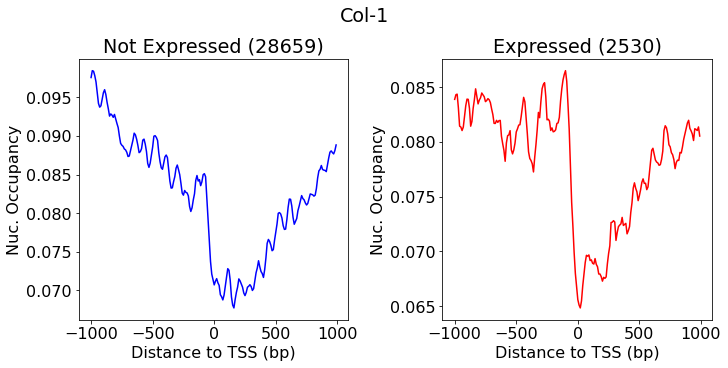

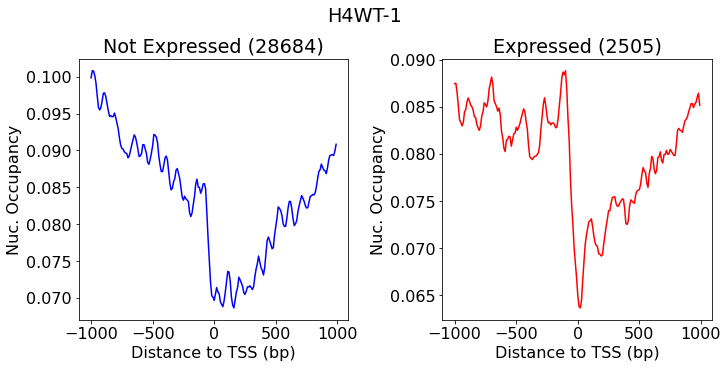

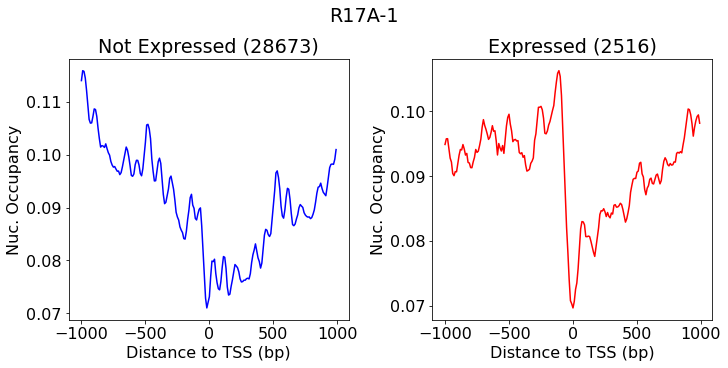

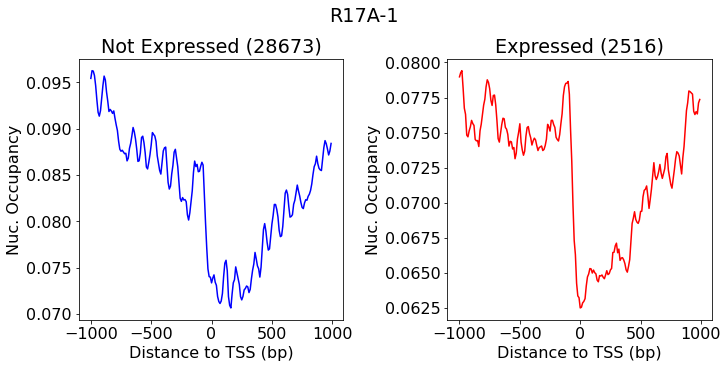

In [30]:
Col1_2subset = tpm_expression_2groups(metadata, Col_tpm, "Col-1.TE.merge.140-160","Col-1.TE.merge.140-160.199", "Col-1")
H4WT1_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "H4WT-1.TE.merge.140-160","H4WT-1.TE.merge.140-160.199", "H4WT-1")
R17A1_2subset = tpm_expression_2groups(metadata, R17A_tpm, "R17A-1.TE.merge.140-160","R17A-1.TE.merge.140-160.199", "R17A-1")
R17A2_2subset = tpm_expression_2groups(metadata, R17A_tpm, "R17A-2.TE.merge.140-160","R17A-2.TE.merge.140-160.199", "R17A-1")

## Reduce Dimensionality and Cluster Data

### tSNE and k-means clustering

In [18]:
#Function to get data and targets from data frame
def get_data_targets(df):
    # Separate out the features
    x = df.iloc[:,range(200)].values
    # Separate out the target
    y = df.loc[:,['expression']].values
    y_cat = df.loc[:,['expressed']].values
    # Standardize the features
    x = StandardScaler().fit_transform(x)
    return x,y,y_cat

In [19]:
#Function to section data frame by gene subset
def subset_genes(df, subset_list):
    return pd.merge(subset_list.loc[:,'gene name'], df, on="gene name").drop(['gene name'],axis=1)

In [20]:
#Function to run tSNE
def run_tsne(x):
    # Convert to adjacency matrix
    adjmat = (np.dot(x, x.T) > 0).astype(int)
    # Remove self loop
    np.fill_diagonal(adjmat, 0)
    # Run tSNE
    tsne_embedded = TSNE(n_components=2, perplexity=30).fit_transform(adjmat)
    return tsne_embedded

In [21]:
#Function to calculate average over all genes in a cluster
def rowsum_clusters(all_data, cluster_label):
    cluster_data = all_data.loc[all_data['cluster'] == cluster_label]
    cluster_data = cluster_data.iloc[:,0:200]
    nrow = cluster_data.shape[0]
    cluster_rowsum = np.array(cluster_data.sum(axis=0))/nrow
    return cluster_rowsum

In [25]:
#Function to plot nucleosome metaprofiles by cluster designation
def plot_cluster_profiles(subset_data, name):
    #Sum rows of different cluster groups
    rowsum_vals = []
    for i in range(4):
        rowsum_vals.append(rowsum_clusters(subset_data,i))
    
    #Produce nucleosome occupancy plots of tpm expression groups
    #Set parameters
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(20, 10)
    
    #Set colors
    cmap = plt.cm.get_cmap('tab10')
    
    #Plot
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[0].plot(x_vals, rowsum_vals[0], c=cmap(0/3))
    axs[0].set_title('Cluster 0')
    axs[1].plot(x_vals, rowsum_vals[1], c=cmap(1/3))
    axs[1].set_title('Cluster 1')
    axs[2].plot(x_vals, rowsum_vals[2], c=cmap(2/3))
    axs[2].set_title('Cluster 2')
    axs[3].plot(x_vals, rowsum_vals[3], c=cmap(3/3))
    axs[3].set_title('Cluster 3')
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/cluster_profiles/"+name)

In [31]:
#Function to perform tSNE and run k-means on a data frame for each individual sample and plot
def tsne_kmeans_4samples(df1, df2, df3, df4, name='test', cluster_num=4, subsample=None):
    if subsample!=None:
        #Subsample data down to 2000 randomly selected genes to make computations feasible on laptop
        df1, df2, df3, df4, = scprep.select.subsample(df1,df2,df3,df4,n=subsample)
        x1 = df1.drop(columns=['gene name', 'expression', 'expressed'])
        x2 = df2.drop(columns=['gene name', 'expression', 'expressed'])
        x3 = df3.drop(columns=['gene name', 'expression', 'expressed'])
        x4 = df4.drop(columns=['gene name', 'expression', 'expressed'])
    else:
        x1 = df1.drop(columns=['DEG', 'gene name', 'expression', 'expressed'])
        x2 = df2.drop(columns=['DEG', 'gene name', 'expression', 'expressed'])
        x3 = df3.drop(columns=['DEG', 'gene name', 'expression', 'expressed'])
        x4 = df4.drop(columns=['DEG', 'gene name', 'expression', 'expressed'])
    
    #Scale data
    x1 = StandardScaler().fit_transform(x1)
    x2 = StandardScaler().fit_transform(x2)
    x3 = StandardScaler().fit_transform(x3)
    x4 = StandardScaler().fit_transform(x4)
    
    # Use tSNE for dimensionality reduction (takes about 10-15 min for 6000 genes)
    tsne_embedded_1 = run_tsne(x1)
    tsne_embedded_2 = run_tsne(x2)
    tsne_embedded_3 = run_tsne(x3)
    tsne_embedded_4 = run_tsne(x4)
    
    # Performs k-means clustering on each sample
    kmeans_labels_subsample = KMeans(n_clusters=cluster_num).fit_predict(tsne_embedded_1)
    df1['cluster'] = kmeans_labels_subsample
    df2['cluster'] = kmeans_labels_subsample
    df3['cluster'] = kmeans_labels_subsample
    df4['cluster'] = kmeans_labels_subsample
    
    #Plot the data
    if subsample==False:
        plt.rcParams.update({'font.size': 22})
        #Color by up- or down-regulation
        fig, axs = plt.subplots(2, 2, constrained_layout=True)
        fig.set_size_inches(20, 15)
        plt.title(name)
        colors = {'up':'crimson', 'down':'deepskyblue'}
        # Plot tSNE scatter plots and label
        axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=df1['DEG'].map(colors))
        axs[0, 0].set_title('Col-1', fontsize=30)
        axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=df2['DEG'].map(colors))
        axs[0, 1].set_title('rH4-1', fontsize=30)
        axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=df3['DEG'].map(colors))
        axs[1, 0].set_title('rH4R17A-1', fontsize=30)
        axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=df4['DEG'].map(colors))
        axs[1, 1].set_title('rH4R17A-2', fontsize=30)
        #Add legend
        classes = ['up', 'down']
        class_colors = ['crimson','deepskyblue']
        recs = []
        for i in range(0,len(class_colors)):
            recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
        plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/tSNE_updown/"+name)
        
    # Color by expression label
    plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    colors = {'yes':'crimson', 'no':'deepskyblue'}
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=df1['expressed'].map(colors))
    axs[0, 0].set_title('Col-1', fontsize=30)
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=df2['expressed'].map(colors))
    axs[0, 1].set_title('rH4-1', fontsize=30)
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=df3['expressed'].map(colors))
    axs[1, 0].set_title('rH4R17A-1', fontsize=30)
    axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=df4['expressed'].map(colors))
    axs[1, 1].set_title('rH4R17A-2', fontsize=30)
    #Add legend
    classes = ['yes', 'no']
    class_colors = ['crimson', 'deepskyblue']
    recs = []
    for i in range(0,len(class_colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
    plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/tSNE_expression/merged-"+name)
    
    # Color by log expression value
    plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=np.log(df1['expression']+1),cmap='coolwarm',vmin=0,vmax=2)
    axs[0, 0].set_title('Col-1', fontsize=30)
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=np.log(df2['expression']+1),cmap='coolwarm',vmin=0,vmax=2)
    axs[0, 1].set_title('rH4-1', fontsize=30)
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=np.log(df3['expression']+1),cmap='coolwarm',vmin=0,vmax=2)
    axs[1, 0].set_title('rH4R17A-1', fontsize=30)
    ax = axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=np.log(df4['expression']+1),cmap='coolwarm',vmin=0,vmax=2)
    axs[1, 1].set_title('rH4R17A-2', fontsize=30)
    #Add legend
    plt.colorbar(ax, label="Log(Expression+1)", orientation="vertical")
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/tSNE_logexpression/merged-"+name)
    
    # Color by k-means cluster label
    plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=kmeans_labels_subsample,cmap='tab10')
    axs[0, 0].set_title('Col-1', fontsize=30)
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=kmeans_labels_subsample,cmap='tab10')
    axs[0, 1].set_title('rH4-1', fontsize=30)
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=kmeans_labels_subsample,cmap='tab10')
    axs[1, 0].set_title('rH4R17A-1', fontsize=30)
    scatter = axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=kmeans_labels_subsample,cmap='tab10')
    axs[1, 1].set_title('rH4R17A-2', fontsize=30)
    #Add legend
    legend1 = axs[1,1].legend(*scatter.legend_elements(), loc="lower right", title="Clusters", bbox_to_anchor=(1.2, 0.35))
    axs[1,1].add_artist(legend1)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/TEs/tSNE_kmeans/merged-"+name)
    
    # Plot metaprofiles of clusters
    plot_cluster_profiles(df1,"Col-1_"+name)
    plot_cluster_profiles(df2,"rH4-1_"+name)
    plot_cluster_profiles(df3,"rH4R17A-1_"+name)
    plot_cluster_profiles(df4,"rH4R17A-2_"+name)

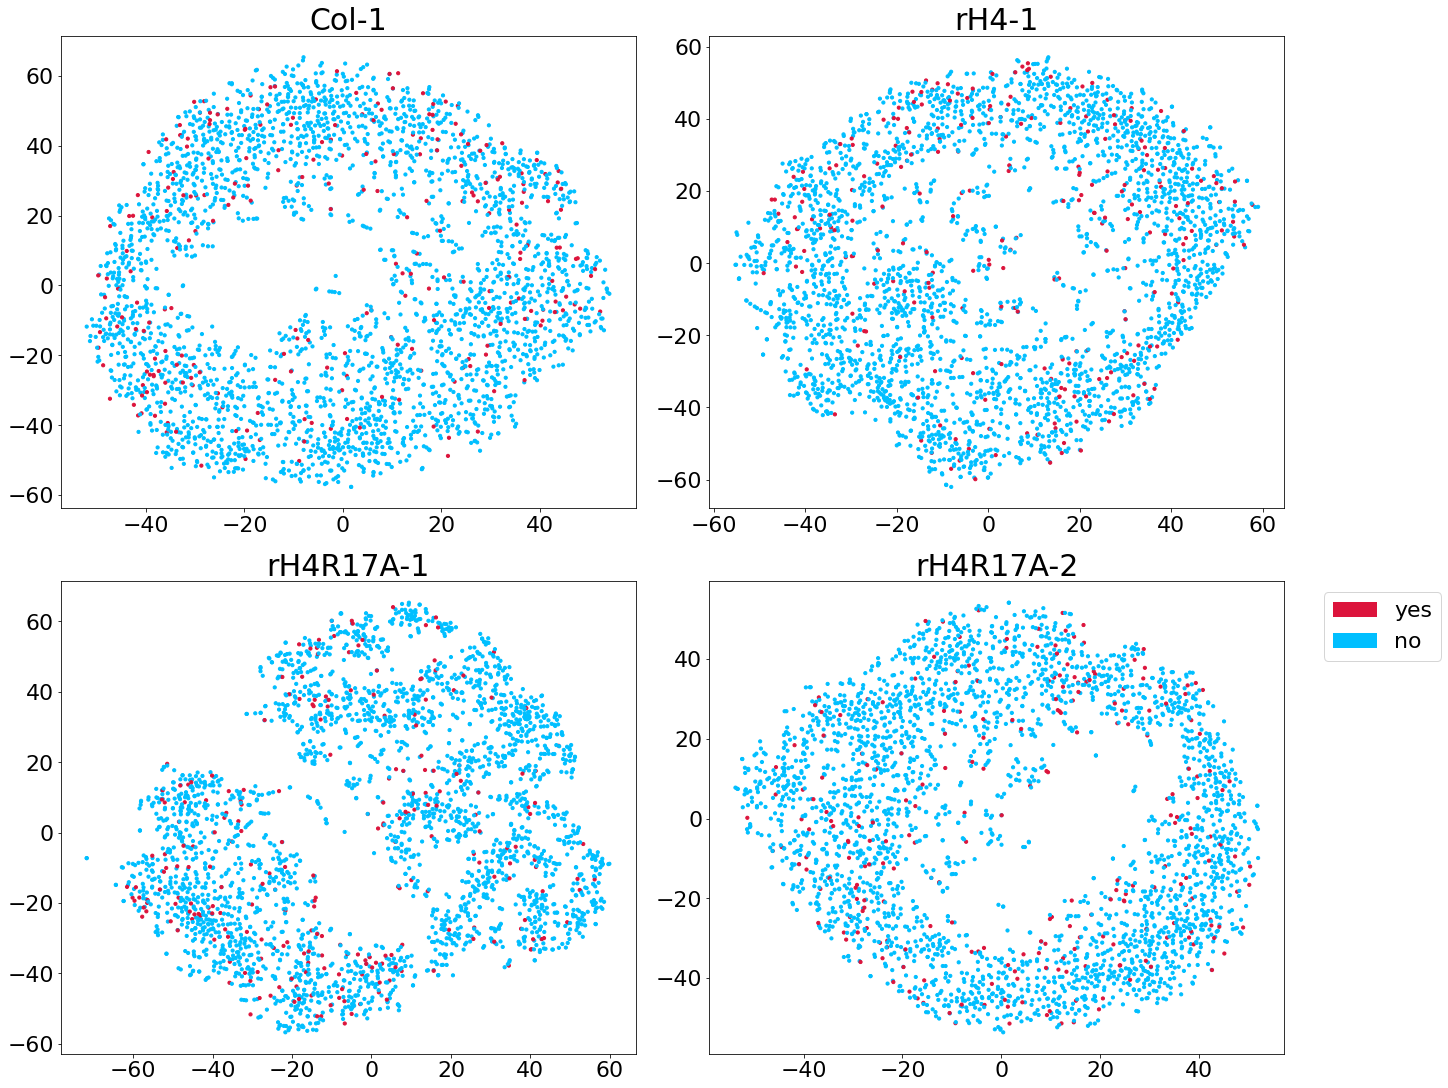

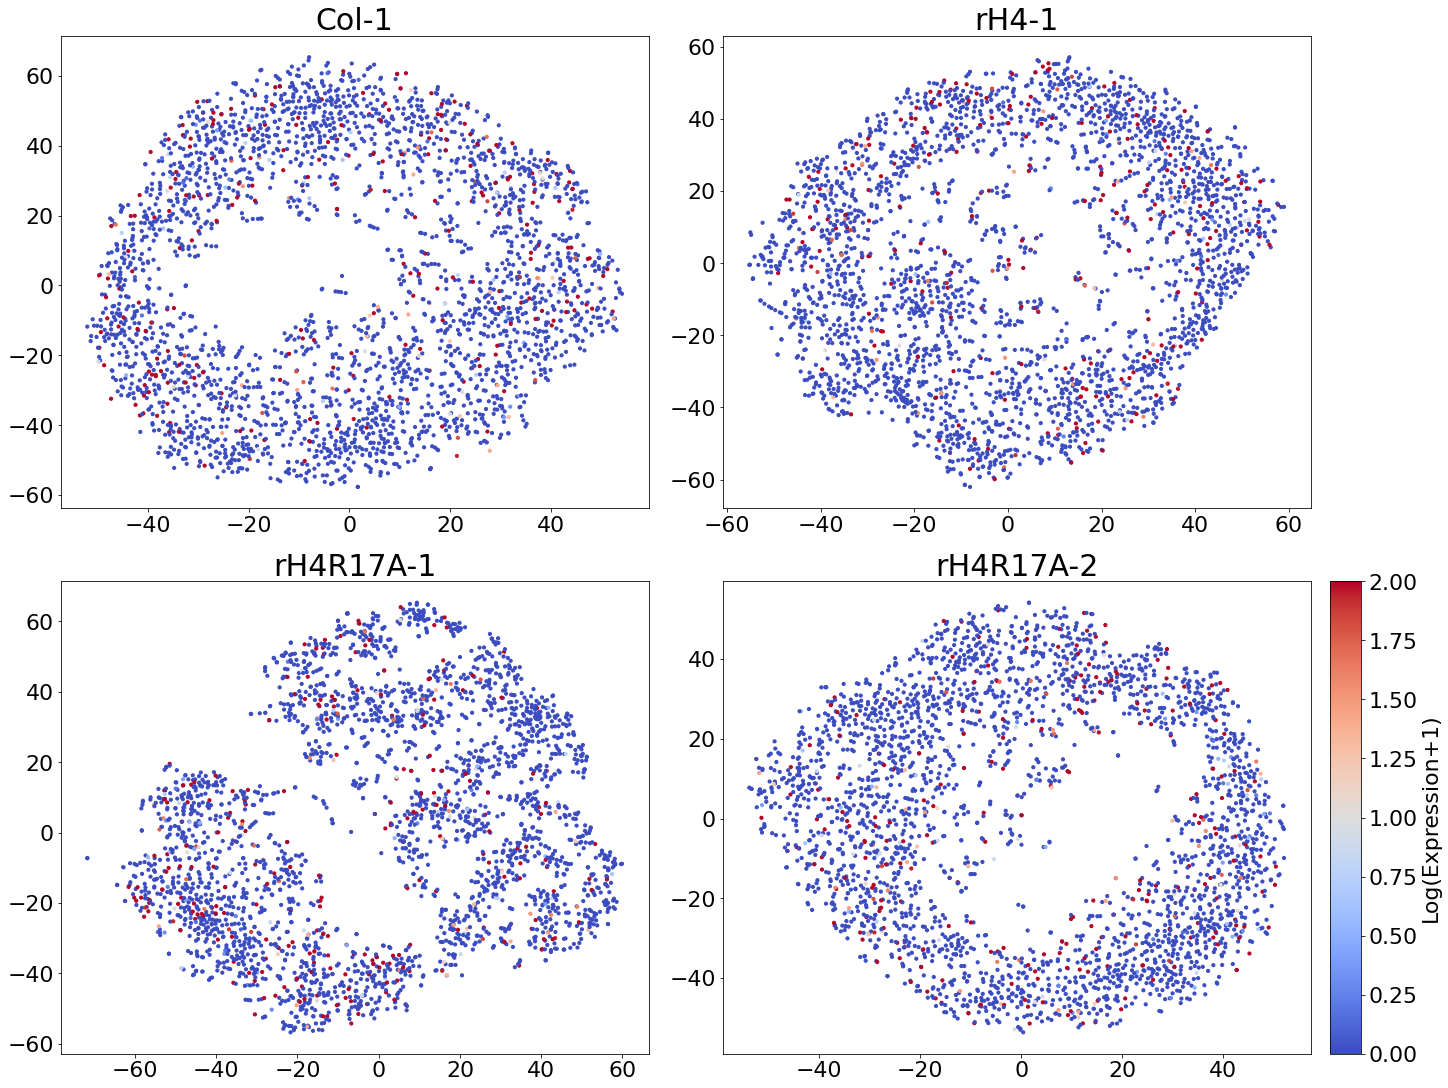

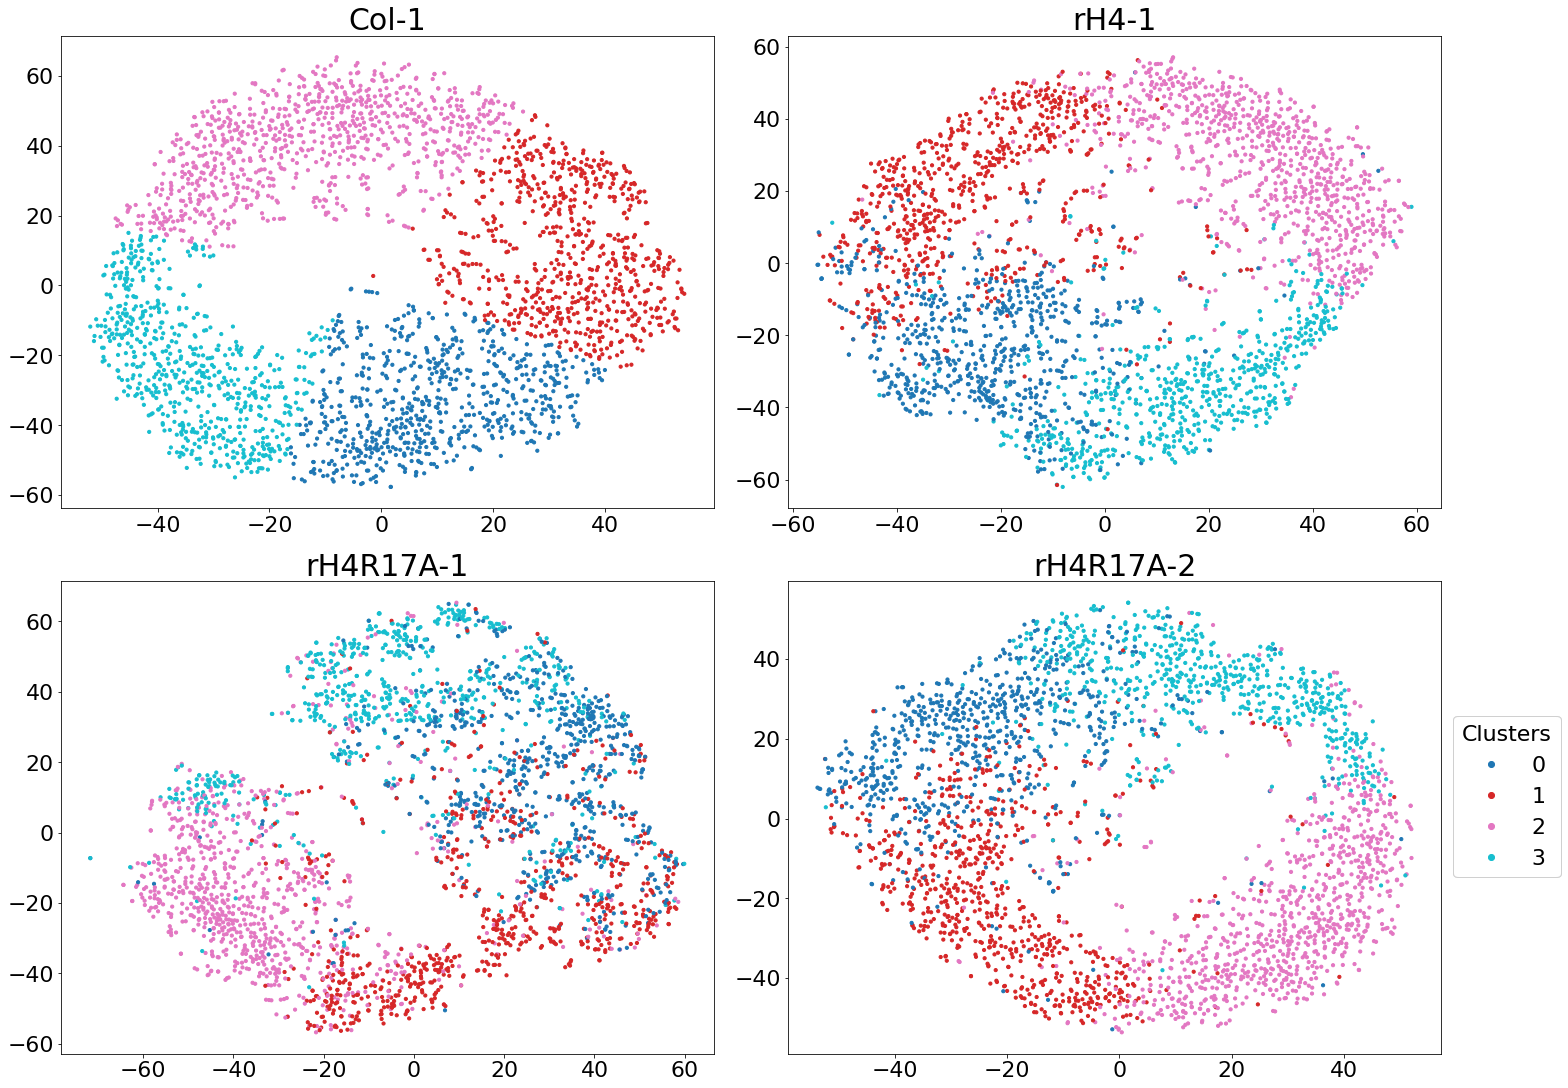

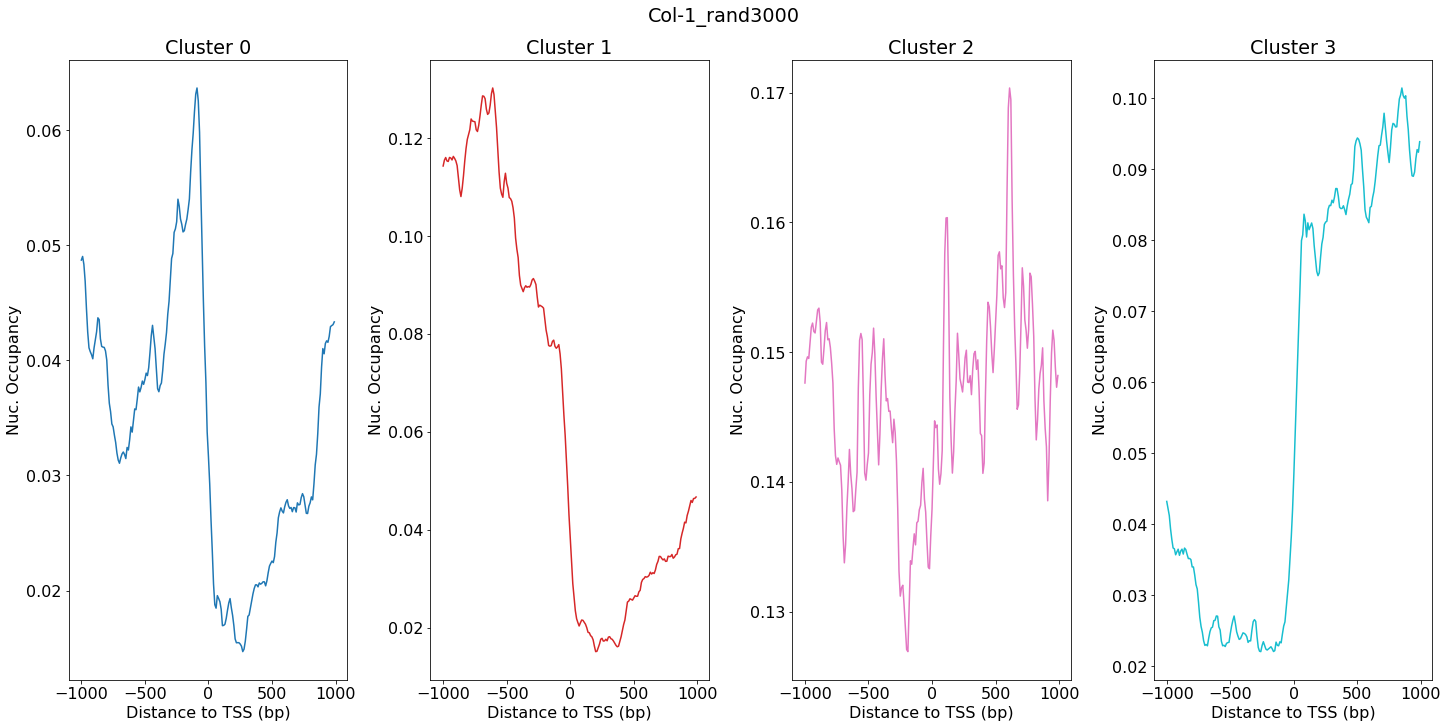

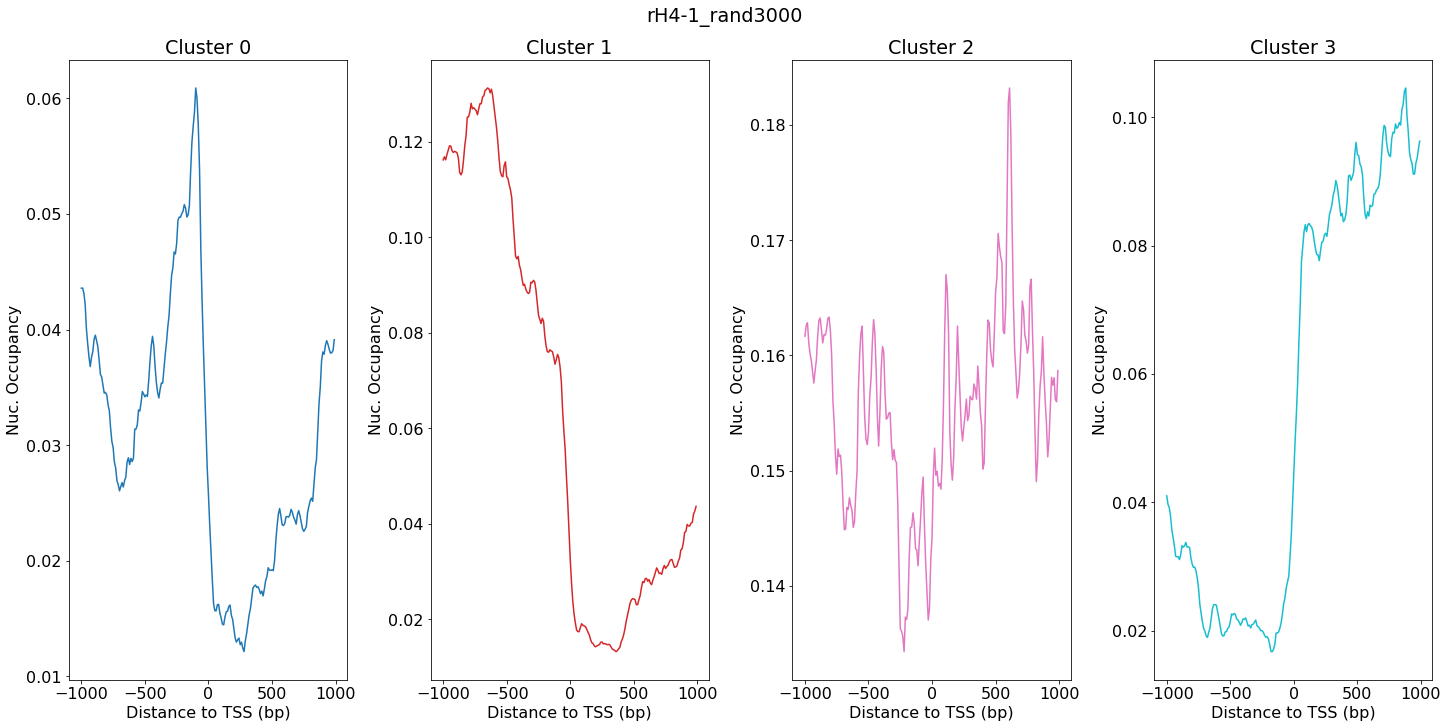

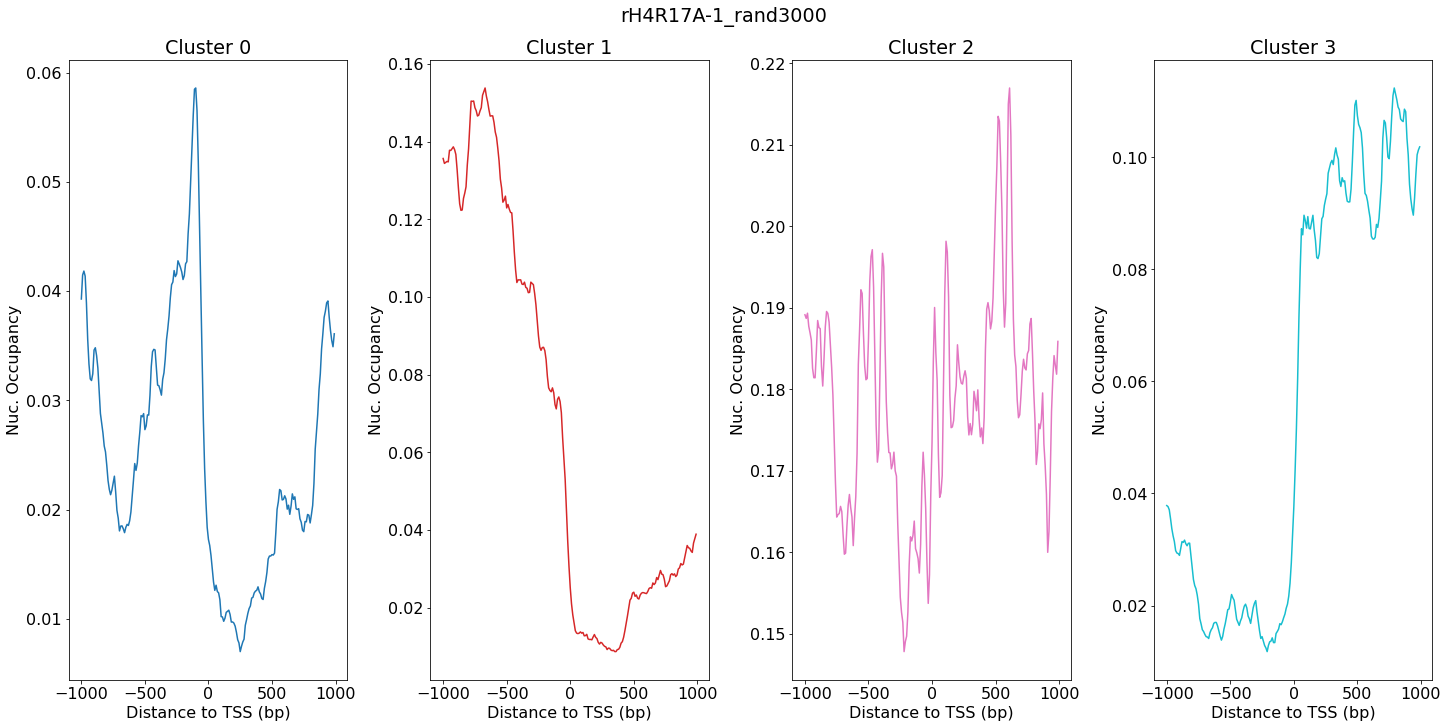

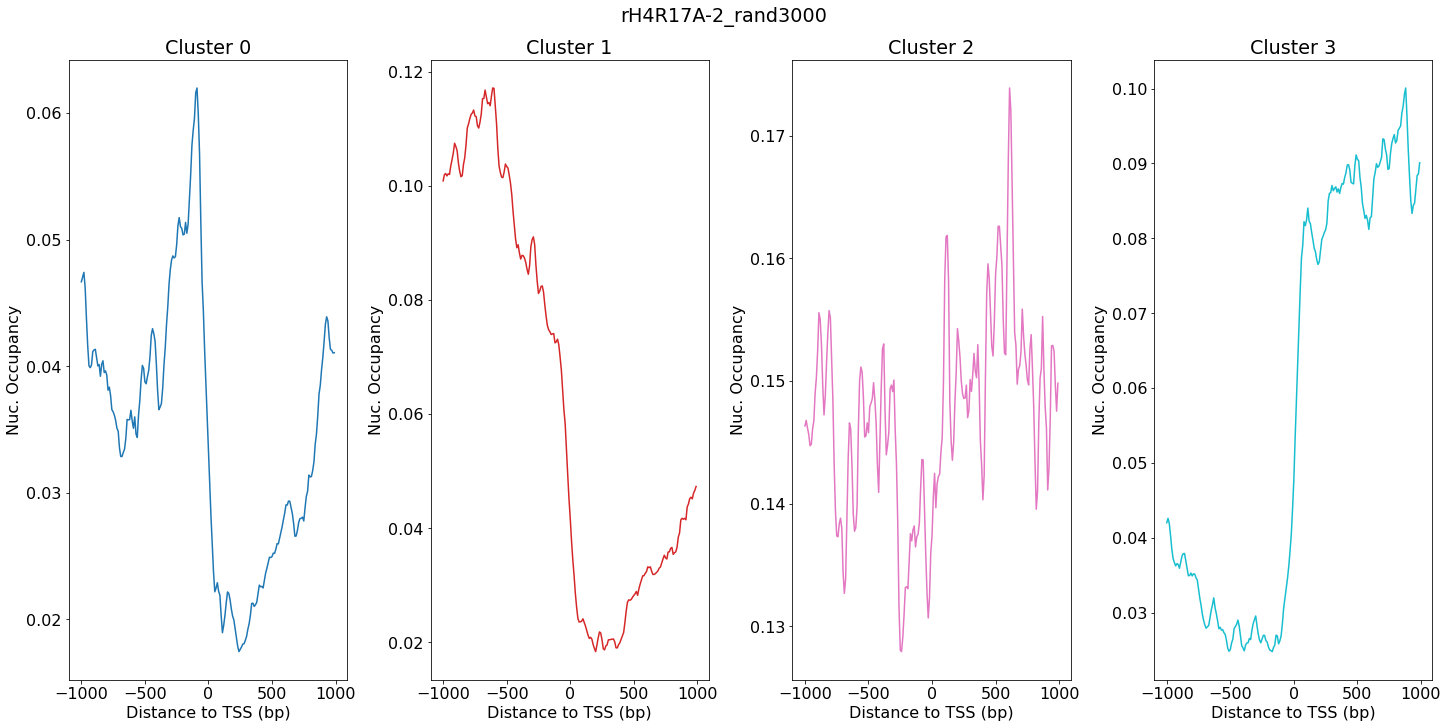

In [32]:
#Plot Random Sample
tsne_kmeans_4samples(Col1_2subset, H4WT1_2subset, R17A1_2subset, R17A2_2subset, name='rand3000', cluster_num=4, subsample=3000)